In [5]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import pysam 
import sys
import copy
import matplotlib.colors
import glob 
from collections import Counter
import scipy.stats as stats

PARENT_DIR = '/home/groups/dpwall/briannac/SARS-CoV-2_structural_variations/'
RAW_READS_TABLE = PARENT_DIR + 'results/raw_reads/all.cov.vcf'
REFERENCE = PARENT_DIR + 'data/reference_genome/NC_045512.2.fasta'
FIG_PATH = PARENT_DIR + 'results/raw_reads/'
BAM_FILE_DIR = PARENT_DIR + 'intermediate_files/raw_reads/'
SVS_TABLE_FILE = PARENT_DIR + 'results/alignment/gisaid_seqs.svs_table_all.tsv'

# Read in raw reads variants

In [139]:
svs = pd.read_csv(SVS_TABLE_FILE, index_col=0)
df_raw_reads = pd.read_csv(RAW_READS_TABLE, sep='\t', header=None)
df_raw_reads.columns = ['ref_genome', 'POS', 'SAMPLE','REF', 'ALT', 'qual', 'pass', 'INFO']

In [165]:
max(df_raw_reads['depth'])

34419

In [142]:
df_raw_reads['AF'] = df_raw_reads['INFO'].apply(lambda x: float(x.split(';')[1].replace('AF=', '')))
df_raw_reads['depth'] = df_raw_reads['INFO'].apply(lambda x: int(x.split(';')[0].replace('DP=', '')))
df_raw_reads['length_REF'] = df_raw_reads['REF'].apply(lambda x:len(x))
df_raw_reads['length_ALT'] = df_raw_reads['ALT'].apply(lambda x:len(x))
df_raw_reads.head()

,ref_genome,POS,SAMPLE,REF,ALT,qual,pass,INFO,AF,depth,length_REF,length_ALT
0,NC_045512.2,2197,SRR11241254,C,CA,47,PASS,"DP=110;AF=0.018182;SB=0;DP4=107,1,2,0;INDEL;HR...",0.018182,110,1,2
1,NC_045512.2,3421,SRR11241254,A,G,201,PASS,"DP=124;AF=0.072581;SB=0;DP4=115,0,9,0",0.072581,124,1,1
2,NC_045512.2,4229,SRR11241254,A,C,60,PASS,"DP=106;AF=0.028302;SB=5;DP4=92,11,2,1",0.028302,106,1,1
3,NC_045512.2,5572,SRR11241254,G,T,4984,PASS,"DP=134;AF=1.000000;SB=0;DP4=0,0,126,8",1.000000,134,1,1
4,NC_045512.2,5673,SRR11241254,CT,C,46,PASS,"DP=131;AF=0.015267;SB=0;DP4=121,9,2,0;INDEL;HR...",0.015267,131,2,1


In [143]:
#df_raw_reads['AF'] = [min(x,1-x) for x in df_raw_reads['AF']]
df_svs = df_raw_reads[(df_raw_reads.length_ALT!=df_raw_reads.length_REF) ]
df_mean_AF = df_svs.groupby('POS').agg(
    {'AF': lambda x: sum((list(x)))/1179, 
     'SAMPLE': lambda x: len(list(x))}).reset_index()
df_mean_AF.index = df_mean_AF['POS']
mean_AF = np.array([df_mean_AF.loc[i]['AF'] if i in df_mean_AF.index else 0 for i in range(1,29904)])

In [81]:
#mean_AF_sv_hotspots = np.array([df_mean_AF.loc[i]['MINOR_ALLELE_FREQ'] if i in df_mean_AF.index else 0 for i in svs['Start Pos'].values])

In [ ]:
df_svs = df_raw_reads[(df_raw_reads.length_ALT!=df_raw_reads.length_REF)]
df_mean_AF = df_svs.groupby('POS').agg(
    {'AF': lambda x: sum((list(x)))/1179, 
     'SAMPLE': lambda x: len(list(x))}).reset_index()
df_mean_AF.index = df_mean_AF['POS']
mean_AF = np.array([df_mean_AF.loc[i]['AF'] if i in df_mean_AF.index else 0 for i in range(1,29904)])

In [144]:
df_svs_minor = df_svs[df_svs['AF']<=.5]
df_mean_AF_minor = df_svs_minor.groupby('POS').agg(
    {'AF': lambda x: sum((list(x)))/1179, 
     'SAMPLE': lambda x: len(list(x))}).reset_index()
df_mean_AF_minor.index = df_mean_AF_minor['POS']
mean_AF_minor = df_mean_AF_minor['AF'].values
mean_AF_minor_sv_hotspots = np.array([df_mean_AF_minor.loc[i]['AF'] for i in svs['Start Pos'].values if i in df_mean_AF_minor.index])

In [158]:
stats.mannwhitneyu(mean_AF_minor_sv_hotspots, mean_AF_minor, alternative='greater')

MannwhitneyuResult(statistic=1097289.5, pvalue=0.005408210008475413)

In [159]:
df_svs_minor = df_svs[df_svs['AF']>=.5]
df_mean_AF_minor = df_svs_minor.groupby('POS').agg(
    {'AF': lambda x: sum((list(x)))/1179, 
     'SAMPLE': lambda x: len(list(x))}).reset_index()
df_mean_AF_minor.index = df_mean_AF_minor['POS']
mean_AF_minor = df_mean_AF_minor['AF'].values
mean_AF_minor_sv_hotspots = np.array([df_mean_AF_minor.loc[i]['AF'] for i in svs['Start Pos'].values if i in df_mean_AF_minor.index])

In [160]:
stats.mannwhitneyu(mean_AF_minor_sv_hotspots, mean_AF_minor, alternative='greater')

MannwhitneyuResult(statistic=2055.5, pvalue=0.0005227420114422762)

# Significance of "indels have high host heterogeneity"

In [ ]:
svs = pd.read_csv(SVS_TABLE_FILE, index_col=0)
raw_reads_svs = df_raw_reads[[r in set(svs['Start Pos']) for r in df_raw_reads['POS'].values]]
print(len(raw_reads_svs))
print(raw_reads_svs)
sv_random = {i:np.random.randint(100,29800) for i in set(svs['Start Pos'])}
svs['Start Pos'] = [sv_random[i] for i in svs['Start Pos']]
print(len(df_raw_reads[[r in set(svs['Start Pos']) for r in df_raw_reads['POS']]].values))

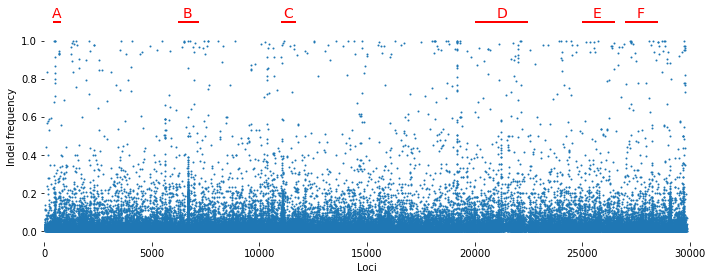

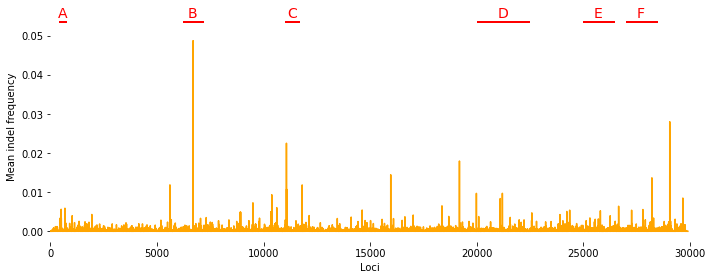

In [93]:
f,ax=plt.subplots(figsize=(10,4))
plt.plot(df_svs['POS'], df_svs['AF'], '.', markersize=2)
plt.xlim(0,30000)
max_y = max(df_svs['AF'])
sv_regions = [('A', 400, 800), ('B',6200, 7200), ('C',11000, 11700), ('D',20000, 22500), ('E',25000, 26500), ('F',27000, 28500)] # For #(20179, 21751)
for label,start,stop in sv_regions:
    ax.hlines(y=1.1*max_y, xmin=start, xmax=stop, linewidth=2, color='r')
    plt.text((start+stop-500)/2,1.12*max_y,label, color='r', size=14)
plt.xlabel('Loci')
plt.ylabel('Indel frequency')
plt.box(on=False)
plt.tight_layout()
#plt.savefig(FIG_PATH + 'read_heterogeneity_scatter.png', dpi=500, transparent=True)
plt.show()

f,ax = plt.subplots(figsize=(10,4))
plt.plot(list(range(1,29904)), mean_AF, '-', color='orange', )
max_y = max(mean_AF)
sv_regions = [('A', 400, 800), ('B',6200, 7200), ('C',11000, 11700), ('D',20000, 22500), ('E',25000, 26500), ('F',27000, 28500)] # For #(20179, 21751)
for label,start,stop in sv_regions:
    ax.hlines(y=1.1*max_y, xmin=start, xmax=stop, linewidth=2, color='r')
    plt.text((start+stop-500)/2,1.12*max_y,label, color='r', size=14)
plt.xlabel('Loci')
plt.xlim(0,30000)
plt.xlabel('Loci')
plt.ylabel('Mean indel frequency')
plt.box(on=False)
plt.box(on=False)
plt.tight_layout()
#plt.savefig(FIG_PATH + 'mean_AF.png', dpi=500, transparent=True)
plt.show()

In [55]:
def PlotReads(bam_file, chrom, start, stop, reference_file, pad=20, max_reads=20, title='raw reads', fig_file=None, seed=42):
    with pysam.AlignmentFile(bam_file, "rb") as samfile:
        reads = [read for read in samfile.fetch(chrom, start=start, stop=STOP)]
    
    ref = [r for r in SeqIO.parse(reference_file, 'fasta')][0].seq
    # Set up data frame
    pos = list(range(start-pad, stop+pad+1))
    df = pd.DataFrame(np.zeros((min(len(reads)+1, max_reads+1),len(pos))))
    labels = pd.DataFrame([['' for _ in range(min(len(reads), max_reads)+1)] for _ in range(len(pos))]).transpose()
    labels.columns = [p+1 for p in pos]
    df.columns = [p+1 for p in pos]


    color_dict={'A':1, 'T':2, 'C':3, 'G':4, None:5, 'N':6}
    np.random.seed(seed)
    np.random.shuffle(reads)
    for i,read in (enumerate(reads)):
        prev_i=0
        query=read.seq
        if i>=(max_reads-1): break
        for (q_i, r_i) in [(q_i, r_i) for (q_i, r_i) in read.get_aligned_pairs() if not ((r_i and (r_i>(stop+pad))) or (r_i and (r_i<(start-pad))))]:
            if type(r_i)!=int: # If INSERTION
                if prev_i==0: 
                    prev_i=r_i
                c_name = str(prev_i) + '.'
                if not (c_name in df.columns):
                    if sum((df.columns==prev_i))==0: break
                    idx=int(np.where(df.columns==prev_i)[0][0]+1)
                    df.insert(copy.copy(idx), c_name, 5.0)
                    labels.insert(idx, c_name, ['-' for i in range(len(labels))])
                prev_i = c_name 
                df.loc[i+1][c_name] = color_dict[query[q_i]]
                labels.loc[i+1][c_name] = query[q_i]
            else: 
                prev_i = r_i
                if type(q_i)!=int:
                    df.loc[i+1][r_i+1]=5
                    labels.loc[i+1][r_i+1] = '-'
                elif q_i>=len(query):
                    break
                    df.loc[i+1][r_i+1] = color_dict[query[q_i]]
                    labels.loc[i+1][r_i+1] = query[q_i]
                else:
                    df.loc[i+1][r_i+1] = color_dict[query[q_i]]
                    labels.loc[i+1][r_i+1] = query[q_i]
    labels.loc[0] = [ref[c-1] if type(c)==int else '-' for c in df.columns]
    labels.columns = [c if type(c)==int else ' ' for c in labels.columns]
    #df.columns = [c if type(c)==int else ' ' for c in df.columns]
    df.loc[0] = [color_dict[ref[c-1]] if type(c)==int else 5 for c in df.columns]
    df['_'] = 0
    df['A']=1
    df['T']=2
    df['C']=3
    df['G']=4
    df['-']=5
    df['N']=6
    labels['_']=''
    labels['A']=''
    labels['T']=''
    labels['C']=''
    labels['G']=''
    labels['-']=''
    labels['N']=''

    f, ax = plt.subplots(figsize=(20,max_reads/2))
    ax.set_aspect('equal')

    msa = sns.heatmap(df, annot=labels, fmt='', ax=ax, cmap=ListedColormap(['white', '#284E60', '#F99B45', '#63AAC0', '#D95980', 'white', 'grey']), cbar=False,
                      xticklabels=round(len(df.columns)/10))
    plt.xticks(rotation=0)
    ax.set_xlim([0,len(df.columns)-6.1])
    ax.axhline(1, *ax.get_xlim(), linewidth=5, color='k')
    ax.axhline(1, *ax.get_xlim(), linewidth=4, color='k')
    plt.yticks([])
    plt.title(title)
    plt.tight_layout()
    if fig_file:
        plt.savefig(fig_file, dpi=500, transparent=True)
    return labels, df


SRR11597141
SRR11597222
SRR11621813
SRR11780047
SRR11577867
SRR11857975


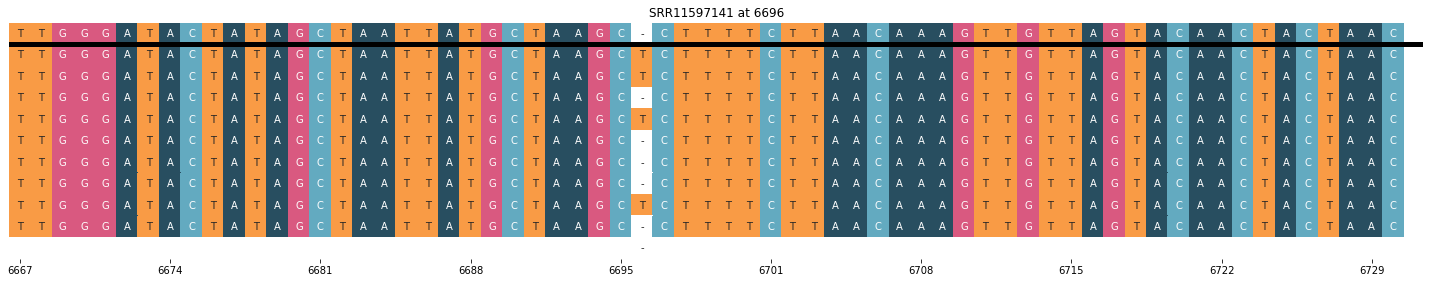

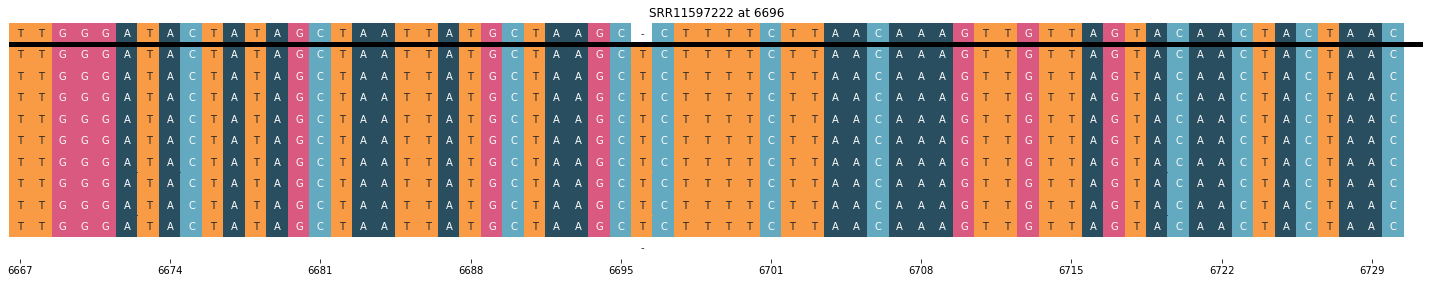

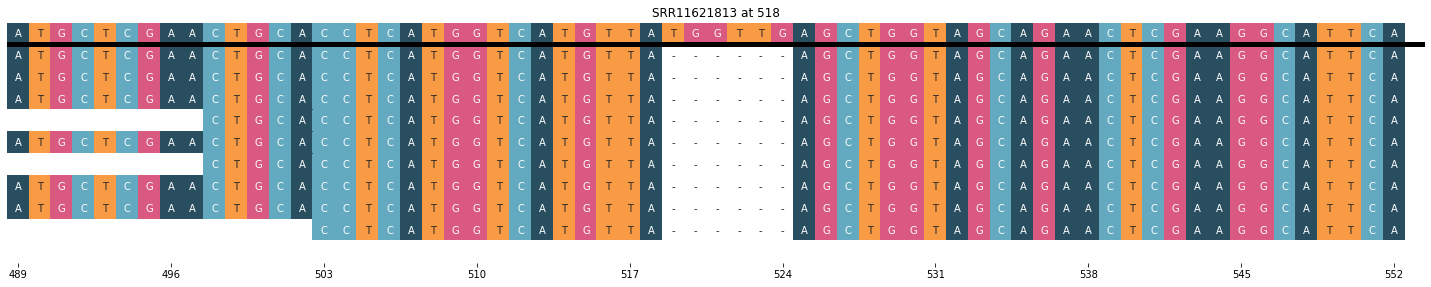

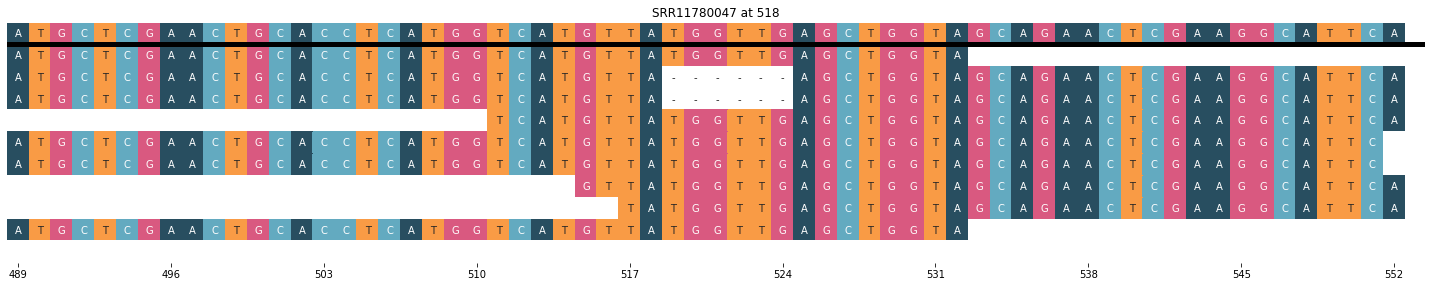

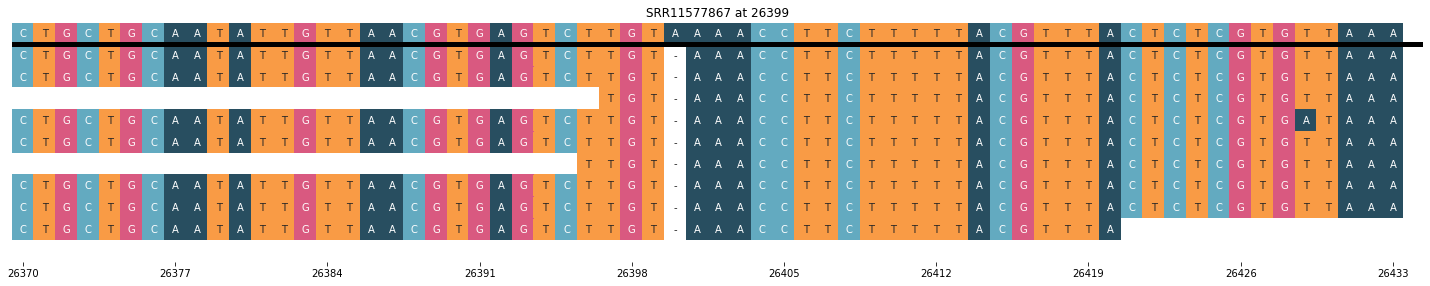

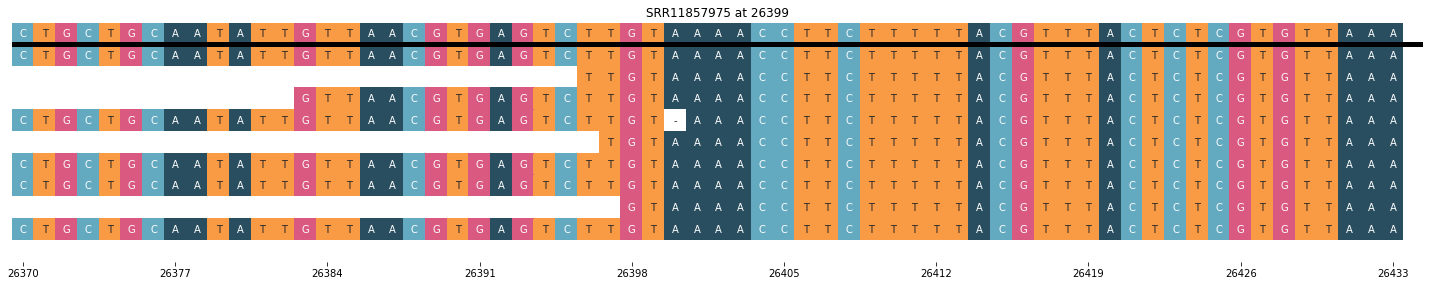

In [57]:
PAD = 30
CHROM = 'NC_045512.2'
MAX_READS=10
for START, NAME, SEED in [(6696,'SRR11597141', 17),
                    (6696, 'SRR11597222', 42), 
                    (518,'SRR11621813', 41),
                    (518, 'SRR11780047', 17),
                    (26399, 'SRR11577867', 42), 
                    (26399, 'SRR11857975', 42)
]:
    STOP = START+3
    print(NAME)
    BAM_FILE = BAM_FILE_DIR + NAME + '.dedup.bam'
    labels, df =PlotReads(BAM_FILE, CHROM, START, STOP, REFERENCE, pad=PAD, max_reads=MAX_READS,
                                  title=NAME + ' at ' + str(START), seed=SEED,fig_file=FIG_PATH + NAME + '_' + str(START) + '.svg')